In [195]:
%matplotlib inline
import warnings
import wave
import struct
import numpy as np
warnings.filterwarnings('ignore')

In [184]:
audio = []
SAMPLE_RATE = 44100
freq_array = np.array([261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88])


def generic_note(freq, duration=1000, volume=1.0, octave=2):
    freq *= octave
    duration *= 2

    for x in range(int(duration * (SAMPLE_RATE / 1000.0))):
        audio.append(volume * np.sin(2 * np.pi * freq * ( x / SAMPLE_RATE )))


def generic_silence(duration=250):
    for x in range(int(duration * (SAMPLE_RATE / 1000.0))): 
        audio.append(0.0)



def save_wav(file_name):

    wav_file=wave.open(file_name,"w")
    wav_file.setparams((1, 2, SAMPLE_RATE, len(audio), "NONE", "not compressed"))
    

    for sample in audio:
        wav_file.writeframes(struct.pack('h', int(sample * 32767.0)))

    wav_file.close()

for i in range(2):
    generic_note(freq=freq_array[1], duration=300)
    generic_note(freq=freq_array[3], duration=250)
    generic_note(freq=freq_array[1], duration=150)
    generic_note(freq=freq_array[1], duration=50)
    generic_note(freq=freq_array[1], duration=50)
    generic_note(freq=freq_array[4], duration=150)
    generic_note(freq=freq_array[1], duration=150)
    generic_note(freq=freq_array[0], duration=150)
    generic_note(freq=freq_array[1], duration=300)
    generic_note(freq=freq_array[5], duration=250)
    generic_note(freq=freq_array[1], duration=150)
    generic_note(freq=freq_array[1], duration=50)
    generic_note(freq=freq_array[1], duration=50)
    generic_note(freq=freq_array[6], duration=150)
    generic_note(freq=freq_array[5], duration=150)
    generic_note(freq=freq_array[3], duration=150)
    generic_note(freq=freq_array[1], duration=150)
    generic_note(freq=freq_array[5], duration=150)
    generic_note(freq=freq_array[6], duration=150)
    generic_note(freq=freq_array[1], duration=150)
    generic_note(freq=freq_array[0], duration=150)
    generic_note(freq=freq_array[0], duration=50)
    generic_note(freq=freq_array[0], duration=50)
    generic_note(freq=freq_array[5], duration=150, octave=1)
    generic_note(freq=freq_array[2], duration=150)
    generic_note(freq=freq_array[1], duration=600)
    generic_note(freq=freq_array[1], duration=300)
    generic_silence(duration=500)

save_wav("output.wav")
    


In [ ]:
from pydub import AudioSegment

first_audio = AudioSegment.from_wav("output.wav")
second_audio = AudioSegment.from_wav("doom.wav")
symbiosis = first_audio.overlay(second_audio)
symbiosis = symbiosis.fade_in(4500).fade_out(4500)

symbiosis.export("symbiosis.wav", format="wav")

In [192]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    samples = np.append(sig, np.zeros(int(np.floor(frameSize/2.0))))
    cols = int(np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    

def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)
    
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]
    
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6)
    
    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()



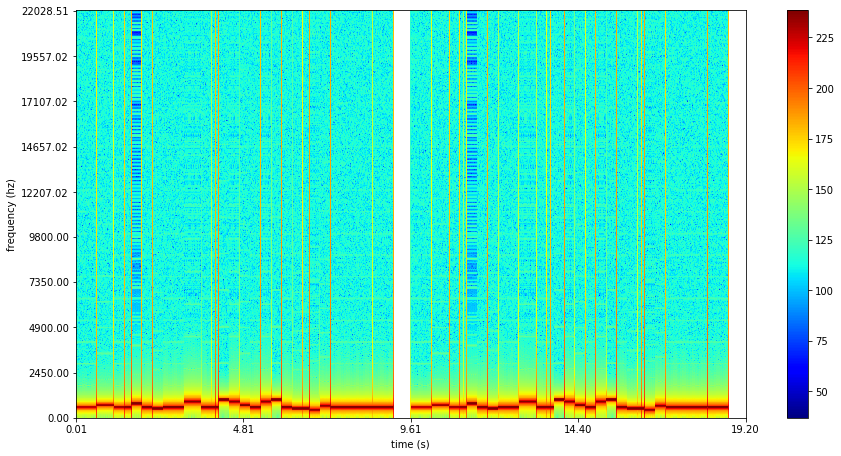

<Figure size 432x288 with 0 Axes>

In [196]:
# Cпектрограмма для моего рингтона
plotstft("output.wav")

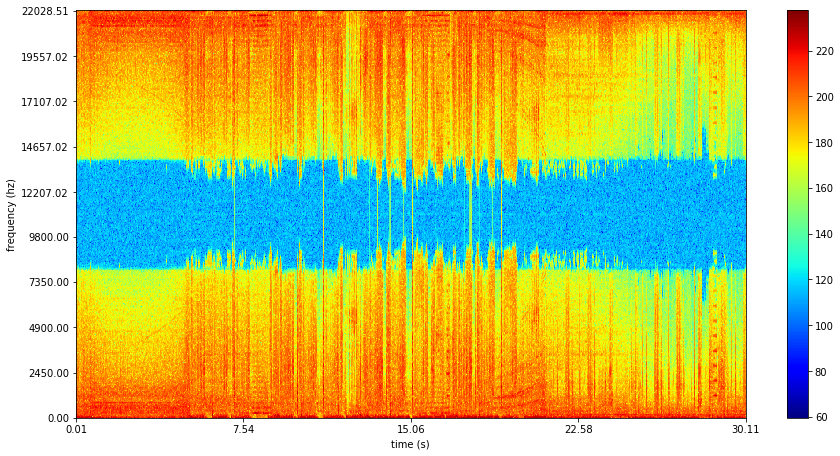

<Figure size 432x288 with 0 Axes>

In [197]:
# Cпектрограмма для отрывка из дума
plotstft("doom.wav")

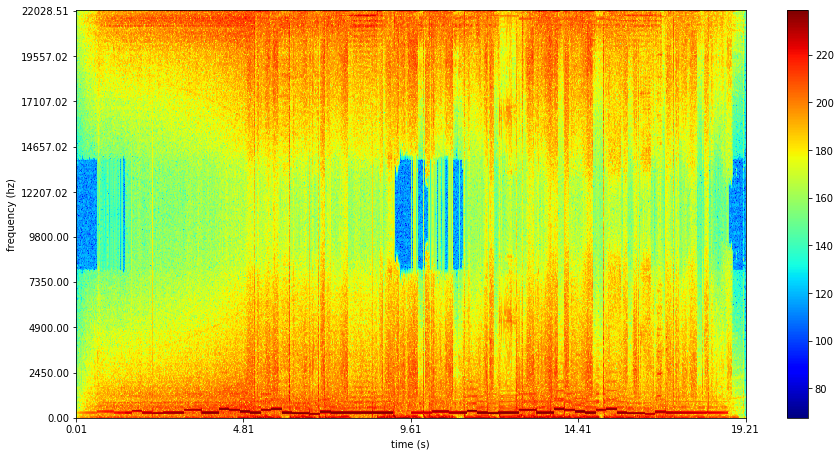

<Figure size 432x288 with 0 Axes>

In [198]:
plotstft("symbiosis.wav")

Вывод: на спектрограммах мы видим, что аудиозапись с крейзифрогом имеет маленькую частоту от 300 до 700. На середине аудиозаписи, есть пауза, она отчетливо видна на спректрограмме, пиксели в этом диапозоне не имеют цвета. Так же, в записи параметр volume не изменяется, поэтому на всем промежутке времени мы это видим. Далее я совместил свою аудиозапись с другой. Звук постепенно вступает, а в конце постепенно затухает. На спектрограмме это отчетливо видно. 